### Train a CNN model on CIFAR10

### Prepare dataset for training

In [2]:
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt

Compile the Transform function

- Transform to tensors
- Normalise in the range of -1 to 1; with a mean of 0.5 and std_dev of 0.5

In [3]:
mean = 0.5
std_dev = 0.5

transform = transforms.Compose([
                                    transforms.ToTensor(),
                                    transforms.Normalize((mean)*3, (std_dev)*3)
])

In [4]:
trainset = torchvision.datasets.CIFAR10(root='./data', download=True, train=True, transform=transform)

Files already downloaded and verified


Dataloader to create batches from the data and shuffle

In [5]:
train_data = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=2, num_workers=2)


Vizualize the dataset

In [6]:
(trainset.classes)


['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

['automobile', 'cat', 'bird', 'frog']


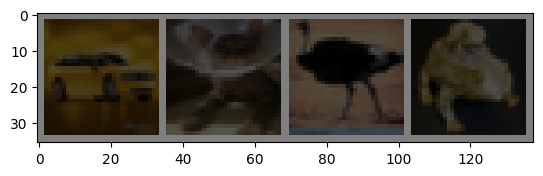

In [7]:
def image_show(img):
    img = (img*std_dev + mean).numpy()
    plt.imshow(np.transpose(img, (1, 2, 0)))

#get some random training images
data_sample = iter(train_data)
images, labels = next(data_sample)

#show images
image_show(torchvision.utils.make_grid(images))

#print labels
print([trainset.classes[l] for l in labels])


Create CNN model

In [8]:
class cnn_model(nn.Module):

    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16*5*5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16*5*5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [9]:
model = cnn_model()

In [10]:
model

cnn_model(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

Loss and Optimizer

In [11]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr = 2e-4, momentum=0.9)

In [12]:
for epoch in range(2):

    running_loss = 0.0
    for i, data in enumerate(train_data, 0):

        inputs, labels = data

        #zero the gradients
        optimizer.zero_grad()

        #forward pass
        outputs = model(inputs)

        #calc loss
        loss = loss_fn(outputs, labels)

        #compute gradients
        loss.backward()

        #update the weights/optimise
        optimizer.step()

        #print training stats
        running_loss += loss.item()
        if (i)%2000 == 1999:
            print('loss:: ', epoch+1, i+1, running_loss/2000)
            running_loss = 0

print('Training Completed!!!')

loss::  1 2000 2.3034899145364762
loss::  1 4000 2.3024567569494248
loss::  1 6000 2.3012224655151368
loss::  1 8000 2.299314240574837
loss::  1 10000 2.2937227264642717
loss::  1 12000 2.2536058691740037
loss::  2 2000 2.0952649393677714
loss::  2 4000 2.0583467817902563
loss::  2 6000 2.0158406229615213
loss::  2 8000 1.9764890969395636
loss::  2 10000 1.9464418104290961
loss::  2 12000 1.9286396166086197
Training Completed!!!


*** Every time the training loop is run, training starts from model parameters saved in memory from last run. Unless the model instance is created again.

Evaluate Model

In [13]:
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
test_data = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=False, num_workers=2)

Files already downloaded and verified


In [14]:
correct = 0
total = 0
with torch.no_grad():
    for data in test_data:
        images, labels = data
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total +=labels.size(0)
        correct += (labels==predicted).sum().item()

print("Accuracy::", 100*correct/total)


Accuracy:: 30.15


Better than random model (10% accuracy)

State dict

In [15]:
for param_tensor in model.state_dict():
    print(param_tensor, model.state_dict()[param_tensor].size())

conv1.weight torch.Size([6, 3, 5, 5])
conv1.bias torch.Size([6])
conv2.weight torch.Size([16, 6, 5, 5])
conv2.bias torch.Size([16])
fc1.weight torch.Size([120, 400])
fc1.bias torch.Size([120])
fc2.weight torch.Size([84, 120])
fc2.bias torch.Size([84])
fc3.weight torch.Size([10, 84])
fc3.bias torch.Size([10])
